In [ ]:
# Install required libraries (if not already installed in Colab)
!pip install datasets scikit-learn

# Step 1: Load dataset from Hugging Face
from datasets import load_dataset
import pandas as pd

ds = load_dataset("thomask1018/credit_card_approval")

# Convert to pandas dataframe
df = ds["train"].to_pandas()

# Step 2: Inspect dataset
print(df.head())
print(df.info())

# Step 3: Preprocess data
# Target column
target = "loan_status"

# Separate features and labels
X = df.drop(columns=[target])
y = df[target]

# Handle categorical variables with one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Handle missing values (if any)
X = X.fillna(0)

# Step 4: Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Train SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create pipeline with scaling + SVM
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=42))
])

# Fit model
svm_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


loan_data.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561  

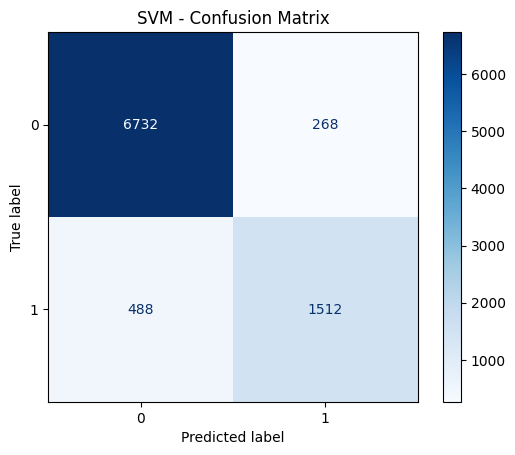

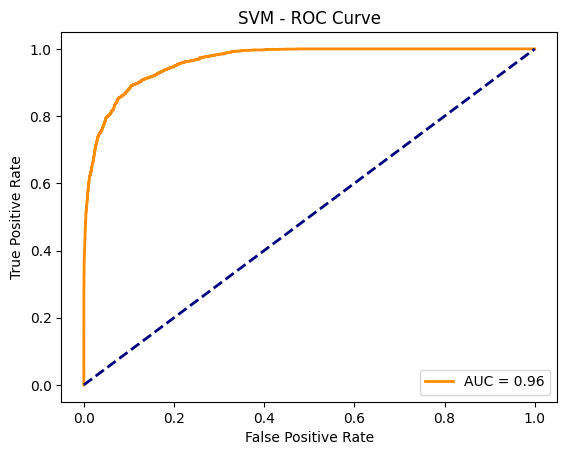

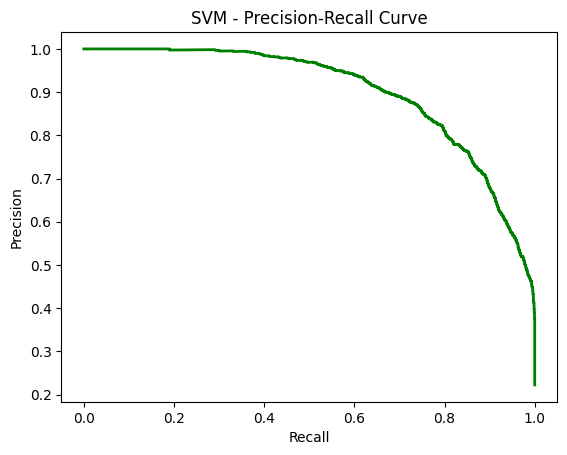

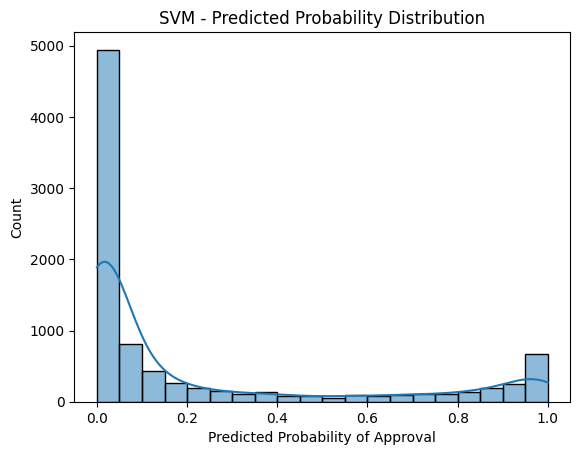

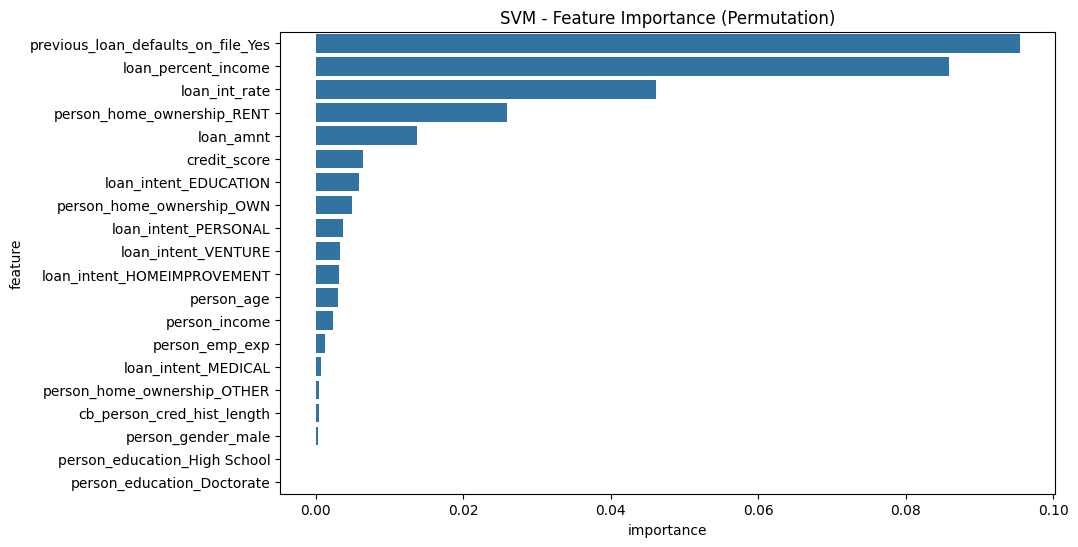

In [ ]:
# -------------------------------
# SVM Graphs / Visualizations
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# 1️⃣ Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, cmap=plt.cm.Blues)
plt.title("SVM - Confusion Matrix")
plt.show()

# 2️⃣ ROC Curve
y_prob = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM - ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 3️⃣ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color="green", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVM - Precision-Recall Curve")
plt.show()

# 4️⃣ Probability Distribution Histogram
plt.figure()
sns.histplot(y_prob, bins=20, kde=True)
plt.title("SVM - Predicted Probability Distribution")
plt.xlabel("Predicted Probability of Approval")
plt.show()

# 5️⃣ Optional: Feature Importance via Permutation (SVM doesn't have built-in)
from sklearn.inspection import permutation_importance

result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
feature_names = X_test.columns
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title("SVM - Feature Importance (Permutation)")
plt.show()


In [ ]:
# --- Prediction Function ---

def predict_loan_status(model, df, sample_dict):
    """
    model: trained sklearn pipeline
    df: original dataframe (for matching column structure after one-hot encoding)
    sample_dict: dictionary with applicant details
    """
    import pandas as pd

    # Convert sample to DataFrame
    sample_df = pd.DataFrame([sample_dict])

    # Apply same preprocessing as training data
    sample_encoded = pd.get_dummies(sample_df, drop_first=True)

    # Align columns with training set
    sample_encoded = sample_encoded.reindex(columns=X.columns, fill_value=0)

    # Predict
    prediction = model.predict(sample_encoded)[0]
    prob = model.predict_proba(sample_encoded)[0]

    return prediction, prob

# --- Example usage ---
sample_applicant = {
    "person_age": 28.0,
    "person_gender": "male",
    "person_education": "Bachelor",
    "person_income": 50000.0,
    "person_emp_exp": 3,
    "person_home_ownership": "RENT",
    "loan_amnt": 15000.0,
    "loan_intent": "EDUCATION",
    "loan_int_rate": 12.5,
    "loan_percent_income": 0.3,
    "cb_person_cred_hist_length": 5.0,
    "credit_score": 700,
    "previous_loan_defaults_on_file": "No"
}

pred, prob = predict_loan_status(svm_model, df, sample_applicant)

print("Prediction:", "APPROVED ✅" if pred==1 else "REJECTED ❌")
print("Probabilities [Rejected, Approved]:", prob)


Prediction: REJECTED ❌
Probabilities [Rejected, Approved]: [0.60673222 0.39326778]
